# Universidad de los Andes

Proyecto presentado por:
* Javier Camilo Garcia Matos
* Daniel Felipe Caro Torres

## Proyecto: Claficador de texto según las 17 ODS

El objetivo del proyecto es desarrollar una solución, basada en técnicas de procesamiento del
lenguaje natural y machine learning, que permita clasificar automáticamente un texto en los
17 ODS, ofreciendo una forma de presentación de resultados a través de una herramienta de
fácil comprensión para el usuario final.

### Planteamiento del problema y solucion

En el marco de los Objetivos de Desarrollo Sostenible (ODS) de la ONU, muchas organizaciones buscan clasificar grandes volúmenes de texto para entender qué partes de la información corresponden a cada objetivo: fin de la pobreza, salud y bienestar, educación de calidad, igualdad de género, etc. Para ello, se pueden usar técnicas de procesamiento de lenguaje natural (NLP) y machine learning, evitando el análisis manual de miles de documentos.

## Objetivo

Desarrollar un modelo basado en técnicas de Machine Leanring usando técnicas de procesamiento de lenguaje natural para facilitar la clasificación de textos de Objetivos de Desarrollo Sostenible para su encontrar relaciones semánticas y facilitar su análisis.

###### Este notebook presentará el desarrollo paso a paso de un clasificador entrenado en textos en español, siguiendo el flujo:

1. Importación y exploración de datos
2. Separación de train/test/validación
3. Preprocesamiento (limpieza, stopwords, stemming, etc.)
4. Vectorización (TF-IDF)
5. Reducción de dimensionalidad (SVD)
6. Entrenamiento y selección de modelo
7. Evaluación (métricas y ejemplos concretos en un conjunto de prueba)
8. Conclusiones

Se finaliza mostrando la clasificación de algunos ejemplos de test, verificando la utilidad del modelo.

#### 1. Importación y exploración de datos

Se importan las como pandas, sklearn, nltk y numpy. En particular, se usa lase siguientes clases y funciones:
* RegexpTokenizer: Tokeniza el texto dividiéndolo en palabras usando una expresión regular. Se usa para eliminar puntuaciones y extraer solo palabras.
* stopwords: Lista de palabras vacías (stopwords) en diferentes idiomas. Se usa para eliminar palabras comunes que no aportan significado (como "el", "de", "y").
* SnowballStemmer: Realiza stemming (reducción de palabras a su raíz) en diferentes idiomas. Se usa para reducir palabras a su forma bas
* CountVectorizer: Convierte texto en una matriz de frecuencia de palabras. Se usa en modelos de NLP para representar texto numéricamente.
* TfidfVectorizer: Convierte texto en una matriz de TF-IDF (Term Frequency - Inverse Document Frequency). Se usa para ponderar palabras según su importancia en un corpus.
* TruncatedSVD: Reduce la dimensionalidad de los datos aplicando SVD (descomposición en valores singulares). Se usa para reducir la matriz de características en NLP.
* LogisticRegression: Implementa un modelo de regresión logística para clasificación. Se usa para clasificar textos en diferentes categorías.
* GridSearchCV: Realiza búsqueda de hiperparámetros usando validación cruzada. Se usa para encontrar los mejores valores de parámetros en modelos de Machine Learning.

In [102]:
import nltk
import numpy as np
import pandas as pd
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer # SnowballStemmer para espa;ol

# entrenar/validar el modelo
from sklearn.model_selection import train_test_split

# Representación de textos
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Reducción de dimensionalidad
from sklearn.decomposition import TruncatedSVD

#-----------------

# Clasificadores 
from sklearn.linear_model import LogisticRegression

# Para métricas de evaluación
from sklearn.metrics import classification_report, confusion_matrix

# Para pipeline y búsqueda de hiperparámetros
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')  


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##### Carga y exploración de datos

In [77]:
df = pd.read_excel('Train_textosODS.xlsx')
df.sample(5)

,textos,ODS
3214,Las organizaciones de mujeres de la sociedad c...,5
9316,Los Estados miembros de la Unión Europea se ha...,16
7521,ResumenLas reglas de jurisdicción e inmunidad ...,16
6609,"En la mayoría de los países, la redistribución...",10
4264,Este capítulo explora cómo una red de defensor...,16


In [78]:
print('Tamaño de los datos:',df.shape)

Tamaño de los datos: (9656, 2)


In [79]:
print('Cantidad de datos nulos:')
print(df.isna().sum())

Cantidad de datos nulos:
textos    0
ODS       0
dtype: int64


In [80]:
print('Cantidad de datos duplicados:')
print(df.duplicated().sum())

Cantidad de datos duplicados:
0


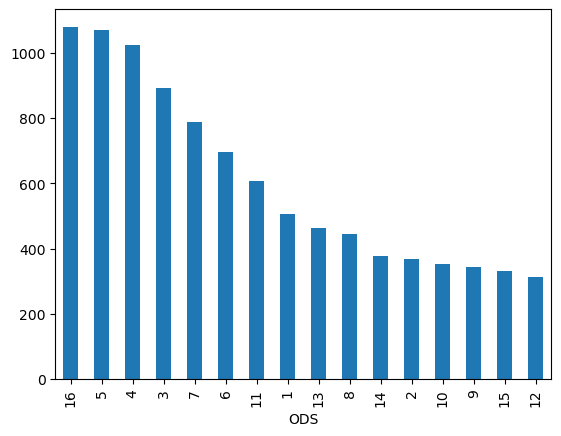

In [109]:
status_counts = df['ODS'].value_counts()
status_counts.plot(kind='bar')
plt.show()

Se evidencia en la grafica anterior que los datos no están balanceados lo cual podría producir sesgos en el modelo.

#### 2. Separación de train/test

In [81]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=0)
print('Cantidad de datos de entrenamiento:',len(df_train))
print('Cantidad de datos de prueba:',len(df_test))



Cantidad de datos de entrenamiento: 7724
Cantidad de datos de prueba: 1932


In [82]:
x_train = df_train['textos']
y_train = df_train['ODS']

x_test = df_test['textos']
y_test = df_test['ODS']

#### 3. Preprocesamiento (limpieza, stopwords, stemming, etc.)

La siguiente función (text_preprocess) actúa de la siguiente manera:
* Divide el texto en palabras usando una expresión regular (\w+) que elimina puntuación.
* Minúsculas: Convierte el texto a minúsculas.
* Eliminación de stopwords: Quita palabras comunes sin significado relevante (como "el", "de", "y").
* Stemming: Reduce las palabras a su raíz (por ejemplo, "corriendo" → "corr").
* Salida: Retorna el texto procesado como una cadena con las palabras transformadas

In [83]:
def text_preprocess(text):
    tokenizer = RegexpTokenizer(r'\w+')
    stemmer = nltk.SnowballStemmer('spanish')  # Stemming en español
    spanish_stops = set(stopwords.words('spanish'))
    
    # minúsculas
    text = text.lower()

    tokens = tokenizer.tokenize(text)
    # remover stopwords
    tokens = [word for word in tokens if word not in spanish_stops]
    # stemming
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)



#### 4. Vectorización (TF-IDF)

Se crea un vectorizador TF-IDF (TfidfVectorizer) que transformará los textos en representaciones numéricas basadas en la Frecuencia de Término - Frecuencia Inversa de Documento (TF-IDF).

In [84]:
vectorizer = TfidfVectorizer(preprocessor=text_preprocess)

#### 5. Reducción de dimensionalidad (SVD)

Se emplea TruncatedSVD para la reducción de dimensionalidad, ya que es particularmente adecuado para datos dispersos, como los obtenidos mediante TF-IDF. A diferencia de otros métodos como PCA, TruncatedSVD no requiere centrar los datos en torno a la media, lo que permite su aplicación eficiente sobre matrices dispersas sin comprometer el rendimiento computacional. Se usa 100 componentes en TruncatedSVD como un punto de equilibrio entre la reducción de dimensionalidad y la preservación de la información.

In [85]:
tsvd = TruncatedSVD(n_components=100, random_state=42)

#### 6. Entrenamiento y selección de modelo

Se hace uso de la Regresión Logística multiclase

In [95]:
clf = LogisticRegression(
    multi_class='multinomial',
    solver='saga', #Utiliza el algoritmo de optimización SAGA, que es eficiente para conjuntos de datos grandes y dispersos.
    max_iter=1000,
    random_state=42
)


Se crea el Pipeline de procesamiento de datos

In [89]:
full_pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('svd', tsvd),
    ('clf', clf)
])


##### Búsqueda de hiperparámetros 

Se buscan los mejores hiperparametros de una lista acotada

In [97]:
param_grid = {
    'svd__n_components': [50, 100, 200], # diferentes reducciones de dimensionalidad
    'clf__C': [0.01, 0.1, 1, 10, 100] # diferentes parámetros de regularización.
}

grid_search = GridSearchCV(
    full_pipeline, 
    param_grid, 
    scoring='accuracy', 
    cv=5,
    verbose=1
)

grid_search.fit(x_train, y_train)
print("Mejores hiperparámetros:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Mejores hiperparámetros: {'clf__C': 10, 'svd__n_components': 200}


#### 7. Evaluación (métricas y ejemplos concretos en un conjunto de prueba)

Se evalúa el modelo rendimiento del modelo en el conjunto de test.

In [98]:
print("Evaluación en conjunto de prueba:")
y_test_pred = best_model.predict(x_test)
print(classification_report(y_test, y_test_pred))


Evaluación en conjunto de prueba:
              precision    recall  f1-score   support

           1       0.80      0.82      0.81        87
           2       0.81      0.73      0.77        64
           3       0.89      0.88      0.88       184
           4       0.94      0.97      0.95       209
           5       0.90      0.91      0.90       189
           6       0.90      0.95      0.92       147
           7       0.92      0.90      0.91       183
           8       0.61      0.60      0.60        94
           9       0.71      0.73      0.72        77
          10       0.69      0.55      0.61        66
          11       0.79      0.81      0.80       117
          12       0.87      0.85      0.86        72
          13       0.86      0.85      0.85        91
          14       0.92      0.81      0.86        73
          15       0.91      0.91      0.91        70
          16       0.89      0.97      0.93       209

    accuracy                           0.86   

El modelo obtuvó un accuracy del 86% lo cual es bueno, pero habría que buscar otros métodos para ver si se puede mejorar.

Text(50.722222222222214, 0.5, 'Verdad')

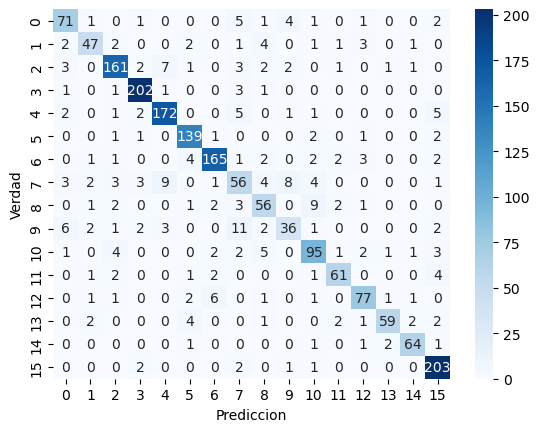

In [105]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm,annot=True,fmt='g',cmap='Blues')
plt.xlabel('Prediccion')
plt.ylabel('Verdad')


En la matriz de confusión se puede en la diagonal ver como el modelo predice la mayoría de los datos de manera correcta.

##### Ejemplos concretos de prediccion

In [94]:
import random

sample_indices = random.sample(list(df_test.index), 4)
for idx in sample_indices:
    raw_text = df_test.loc[idx, 'textos']
    true_label = df_test.loc[idx, 'ODS']
    pred_label = best_model.predict([raw_text])[0]
    
    print("="*60)
    print(f"Texto:\n{raw_text}\n")
    print(f"ODS real: {true_label}")
    print(f"ODS predicho: {pred_label}")
    print("="*60, "\n")


Texto:
La prevalencia de niños con retraso en el crecimiento fue mayor en los grupos más pobres en casi todos los países en los que se disponía de datos de encuestas de nutrición recientes.5 En algunos países, la prevalencia entre el grupo más pobre era casi el doble del promedio nacional (Figura 9). Si bien la prevalencia de niños con sobrepeso es mayor en los grupos de mayores ingresos en la mayoría de los países, los grupos más pobres tuvieron una mayor prevalencia en Armenia y Serbia. La desnutrición, tanto la desnutrición como el sobrepeso, son problemas multicausales.

ODS real: 2
ODS predicho: 1

Texto:
Esta diferencia, sin embargo, varía significativamente según el grupo socioeconómico. Mientras que el 44,1% de los estudiantes del PIE de nivel socioeconómico bajo son diagnosticados con una necesidad especial permanente, solo el 12% de los estudiantes del PIE de nivel socioeconómico alto son diagnosticados con dicha necesidad (ver Figura 3.5). También hay diferencias por proveed

#### 8. Conclusiones

##### 1) Preparacion de datos y reduccion de al dimensionalidad:

 - Se ha justificado el uso de TF-IDF por resaltar términos relevantes 
     y SVD por condensar la información en menos dimensiones (50, 100 o 200), 
     mejorando tiempo de entrenamiento y reduciendo ruido.

##### 2) Resultados del modelo

El modelo alcanzó un desempeño destacado al clasificar automáticamente textos en relación con los distintos ODS. En promedio, la exactitud rondó alrededor del 86% en el conjunto de prueba, lo cual indicó que la mayoría de las clases fueron reconocidas con buenos valores de precisión, recall y f1-score. Sin embargo, se evidenció que ciertos ODS con menos ejemplos disponibles presentaron resultados más modestos, lo que sugirió la necesidad de recopilar más datos o ajustar algunas fases del preprocesamiento para mejorar aún más la robustez del modelo.

Asimismo, la reducción de dimensionalidad mediante SVD contribuyó a una mayor eficiencia y a evitar el sobreajuste en un espacio inicial muy extenso producto de la representación TF-IDF. Esto, sumado a la búsqueda de hiperparámetros a través de GridSearchCV, permitió afinar los valores óptimos para la regresión logística, logrando un equilibrio entre complejidad y rendimiento. En última instancia, el uso de métricas globales y de ejemplos concretos demostró la solidez del enfoque para clasificar grandes volúmenes de texto en español, brindando una base confiable para su aplicación en contextos reales de análisis y toma de decisiones sobre los ODS.


##### 3) Ejemplos reales:

   - Se mostraron 4 textos del conjunto de prueba, junto a la 
     etiqueta real y la predicción, evidenciando la utilidad del modelo 
     para clasificar nuevos documentos.